## Pandasから得られたユーザログを触ってみる

このノートブックは「5章 ユーザの反応をあつめる仕組みを作る」のうち
「5-3-7 Pandasから得られたユーザログを触ってみる」で利用するノートブックになります。

### データの読み取りを行う

このデータの確認の操作のためにはJupyter Notebook上ないしはIPythonコンソールの利用がお手軽です。
データ処理ライブラリである`pandas`には、jsonファイルを読み込む関数として`pandas.read_json`関数があらかじめ用意されています( https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html ）。

この`lines`オプションを指定することで、1行1json形式なファイルの読み込みを行うことができます。

In [2]:
import pandas as pd

# 相対パスでによりファイル読み込みを行うため
# 下記のパスは各自で確認すること
#  - 現在のディレクトリを確認するには, `!pwd`
#  - 現在のディレクトリ
path = "./webapp/data/event.jsonl"
df = pd.read_json(path, lines=True)

df.head()

,event,host,path,received_at,referrer,target,timestamp,user_agent,user_id
0,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:41:06.342,,BODY,2019-02-17 14:41:06.145,{'raw': 'Mozilla/5.0 (Macintosh; Intel Mac OS ...,0260d36c-56ce-4819-b855-bad36963b537
1,DOMContentLoaded,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:41:06.896,,#document,2019-02-17 14:41:06.688,{'raw': 'Mozilla/5.0 (Macintosh; Intel Mac OS ...,0260d36c-56ce-4819-b855-bad36963b537
2,load,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:41:06.906,,IMG,2019-02-17 14:41:06.704,{'raw': 'Mozilla/5.0 (Macintosh; Intel Mac OS ...,0260d36c-56ce-4819-b855-bad36963b537
3,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:41:07.641,,BODY,2019-02-17 14:41:07.446,{'raw': 'Mozilla/5.0 (Macintosh; Intel Mac OS ...,0260d36c-56ce-4819-b855-bad36963b537
4,DOMContentLoaded,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:41:08.222,,#document,2019-02-17 14:41:08.021,{'raw': 'Mozilla/5.0 (Macintosh; Intel Mac OS ...,0260d36c-56ce-4819-b855-bad36963b537


In [9]:
# ファイルは分割されるため、個別に読み込んで結合する必要がある
from functools import partial
from glob import glob
import pandas as pd

reader = partial(pd.read_json, lines=True)
df = pd.concat(map(reader, glob("./webapp/data/event.*")))

df.shape

(69, 9)

### 入れ子構造となっているメンバを展開する

`user_agent`は入れ子構造になっており、pandasのデフォルトの読み込み動作では辞書型として解釈されてしまいます。
このような入れ子構造をpandas上で便利にあつかために入れ子構造となっているメンバを展開しておくのが良いでしょう。

この操作を行うには、`pandas.io.json.json_normalize`関数を重宝します。(https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.io.json.json_normalize.html)

In [10]:
import json
from pandas.io.json import json_normalize

df_ua = json_normalize(list(df['user_agent'])).add_prefix('user_agent.')
df_flattened = df.join(df_ua).drop('user_agent', axis=1)
df, df_old = df_flattened, df

df_flattened.head()

,event,host,path,received_at,referrer,target,timestamp,user_id,user_agent.browser,user_agent.language,user_agent.platform,user_agent.raw,user_agent.version
0,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:40:29.041,,IMG,2019-02-17 14:40:28.849,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109
0,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:41:06.342,,BODY,2019-02-17 14:41:06.145,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109
0,DOMContentLoaded,c3fe5aa2.ngrok.io,http://c3fe5aa2.ngrok.io/,2019-02-17 13:54:06.602,,#document,2019-02-17 13:54:06.406,32ab03cf-4bed-4d7a-98bb-41181c30b989,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109
0,click,c3fe5aa2.ngrok.io,http://c3fe5aa2.ngrok.io/,2019-02-17 13:52:08.781,,BODY,2019-02-17 13:52:08.584,f42569aa-452a-4ef2-9054-d886236ed4bb,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109
1,DOMContentLoaded,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:40:35.002,,#document,2019-02-17 14:40:34.789,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109


### ユーザの訪問回数をかぞえあげる

ユーザログからユーザの訪問回数を数え上げてみましょう。
ユーザログから訪問回数をかぞえあげるには`event="DOMContentLoaded"`であるレコードを数え上げれば良いです。
`pandas`のデータフレームでこれを数え上げてみましょう。

In [11]:
len(df[df.event == "DOMContentLoaded"])

20

Webサービスでは訪問回数であるpageviewだけでなく、どれぐらい個別のユーザが計測しているかを測るケースも多いです。
このような数値はユニークユーザ数(UU数)と呼ばれます。
これも実際に算出してみましょう。

In [12]:
df[df.event == "DOMContentLoaded"].user_id.nunique()

10

まとめて集計する際には、`pandas.DataFrame.describe`関数も非常に有用です。
レコード中のいくつかのカラムについてこれを確認してみましょう。

In [13]:
df[["event", "host", "path", "user_id"]].describe()

,event,host,path,user_id
count,69,69,69,69
unique,3,1,2,35
top,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,0260d36c-56ce-4819-b855-bad36963b537
freq,29,69,35,35


### クライアントからサーバに届くまでの時間をグラフで表示してみる

ブラウザでログが発火してからサーバに届くまでには、時差があります。
これをログから実際に確認してみましょう。

In [14]:
tdiff = (df.received_at - df.timestamp)
tdiff.describe()

count                        69
mean     0 days 00:00:00.202014
std      0 days 00:00:00.028288
min      0 days 00:00:00.178000
25%      0 days 00:00:00.190000
50%      0 days 00:00:00.197000
75%      0 days 00:00:00.205000
max      0 days 00:00:00.410000
dtype: object

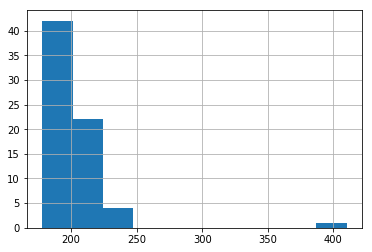

In [22]:
# グラフ表示の際には、時間単位で割り算を行うことで簡単にグラフを表示することができる
(tdiff / pd.Timedelta(milliseconds=1)).hist()

ログの送信からサーバ側で受信にかかる時間は一定ではなく、ムラがあることがわかります。
また異常値もあり、最大で400msがかかっていることがわかります

### ログのセッション処理を行う

Webサービスでは、ユーザが訪れてからそのサービスを離れるまでの区切りとしてセッションと呼ばれる単位があります。
例えば訪問したユーザが同じユーザIDを持っていたとしても、週末と平日、昼と朝など利用の時間帯が異なればユーザ行動の性質も異なると予想されます。
これまでのログ実装ではあくまで個別のユーザの認識はできますが、セッション単位での区別を行うことはできません。
一方で、セッション単位で時間的な区切りを設けられている方が、粒度のより細かい挙動をつかむことができるようになるでしょう。

ここではpandas上で読み込みを行ったログデータに対してセッション区切りを付与する処理を行います。
このような処理は**セッショナイズ(sessionize)**と呼ばれます。

#### リクエスト間の時間差を計算する

セッショナイズを行うために、前のリクエスト単位から今のリクエストの時間差を算出する必要があります。
まずはこれを算出しましょう

In [16]:
df_sorted = df.sort_values(["user_id", "timestamp"])

ts = df_sorted.timestamp
ds_span = ts.shift(-1) - ts

# 時差が負は並び替えた後、同じユーザではありえないため未定義とする
ds_span = ds_span.apply(lambda t: t if t > -t else pd.NaT)
df_sorted["time_delta"] = ds_span.shift(1)
df_sorted.head()

,event,host,path,received_at,referrer,target,timestamp,user_id,user_agent.browser,user_agent.language,user_agent.platform,user_agent.raw,user_agent.version,time_delta
13,DOMContentLoaded,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:38:29.922,,#document,2019-02-17 14:38:29.718,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109,NaT
14,load,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:38:31.041,,IMG,2019-02-17 14:38:30.838,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109,00:00:01.120000
15,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:38:31.782,,BODY,2019-02-17 14:38:31.566,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109,00:00:00.728000
16,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:38:38.531,,IMG,2019-02-17 14:38:38.332,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109,00:00:06.766000
17,click,c3fe5aa2.ngrok.io,https://c3fe5aa2.ngrok.io/,2019-02-17 14:38:39.121,,BODY,2019-02-17 14:38:38.913,0260d36c-56ce-4819-b855-bad36963b537,chrome,None,macos,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,72.0.3626.109,00:00:00.581000


#### セッションの境界を定める

前のリクエストからの時間差が求められたところで、セッショナイズを行っていきましょう。
セッショナイズを行うための手順は次の手順で求められます。

0. セッション間の最大間隔を定める
0. ユーザID、時間順に並び替えられたレコードから、セッションの境界を求める。
0. セッションの区間ごとに数値を割りふる。
0. ユーザIDとセッション固有番号から固有のセッションIDを生成する

まずは、最初にセッションの区切りとなる時間間隔を定めましょう。
これはサービス開発者側で自由に定めて良いですが、一般的には15分という指標が採用されることが多いです。
経験的なユーザの平均滞在時間等から定めると良いでしょう。

ここでは1分というセッション時間の区切りを採用します。
これは「前のリクエストから1分以上開いた場合には、ユーザは別のセッションとなる」ことを意味します。



In [17]:
# セッションの境界となりうるレコードを判定する
is_boundary = (df_sorted.time_delta.isnull() | (df_sorted.time_delta > pd.Timedelta(minutes=1)))

セッションの区間ごとに数値を割り振るには、求めたbooleanの数列の累積和をとると簡単に求めることができます。

In [18]:
# 異なるセッションのたびに数値が加算される数列になる
# (s1 s2 s2 s3 ...) -> (0 1 1 2 ...)
cumsum_boundary = is_boundary.cumsum()
cumsum_boundary.tail()

5     22
10    22
7     23
0     24
1     24
Name: time_delta, dtype: int64

セッションごとに番号のわりふりができたところで、最後にハッシュ関数を用いてセッションIDを生成しましょう。

セッションIDを生成するには、ユーザIDとセッション番号を組み合わせることでセッション固有のIDを生成することができます。
Webサーバの際に利用したハッシュ関数をそのままもちいて、カラム`session_id`を作りましょう

In [19]:
import hashlib

def hashing(user_id, num):
    val = f"{user_id}-{num}".encode('utf8')
    return hashlib.md5(val).hexdigest()

_df = df_sorted
_df["__ss"] = cumsum_boundary 
df_sorted["session_id"] = _df.apply(lambda r: hashing(r.user_id, r.__ss), axis=1)

セッションIDを正しくつくることができたかを確認するために、実際にデータを確認してみましょう。

- 前のリクエストから1分以上経過している場合にセッションIDは変わる
- 時系列においてユーザIDが変わるたびにセッションIDは変わる

の2点を確認すると良いでしょう。

In [21]:
df_sorted[["event", "user_id", "session_id", "timestamp"]].sort_index().head(n=20)

,event,user_id,session_id,timestamp
0,click,0260d36c-56ce-4819-b855-bad36963b537,744aa36a7668d6ff49ef2b88545d1b9a,2019-02-17 14:41:06.145
0,click,f42569aa-452a-4ef2-9054-d886236ed4bb,5c289d8961d6a0a32fea297b0587d741,2019-02-17 13:52:08.584
0,DOMContentLoaded,32ab03cf-4bed-4d7a-98bb-41181c30b989,74059eeaf657c349146454ee4d1f20c2,2019-02-17 13:54:06.406
0,click,0260d36c-56ce-4819-b855-bad36963b537,744aa36a7668d6ff49ef2b88545d1b9a,2019-02-17 14:40:28.849
1,DOMContentLoaded,0260d36c-56ce-4819-b855-bad36963b537,744aa36a7668d6ff49ef2b88545d1b9a,2019-02-17 14:41:06.688
1,DOMContentLoaded,0260d36c-56ce-4819-b855-bad36963b537,744aa36a7668d6ff49ef2b88545d1b9a,2019-02-17 14:40:34.789
1,click,f8c0ca84-01dc-459a-af16-46cc52d99cd7,f3dddbd82f1732a364747fbeb353144a,2019-02-17 13:52:10.912
1,load,8dbd8c0e-cae4-4e39-b7af-fbbd35291863,60f93cb5490a87384f40e161c145bcdf,2019-02-17 13:54:06.587
2,click,2561c95e-f253-4050-a80a-af253068baf9,f1e6f097bc65864d7008825f89c00087,2019-02-17 13:52:46.575
2,load,0260d36c-56ce-4819-b855-bad36963b537,744aa36a7668d6ff49ef2b88545d1b9a,2019-02-17 14:41:06.704
